# Finding solar panels

The purpose of this notebook is to experiment using the fastai library to try and detect solar panels on roofs. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai import *
from fastai.metrics import error_rate
import pandas as pd

The current training dataset used only contains 60 images. I'm going to use a small batch size for this.

In [13]:
bs = 8

## Looking at the data

We are going to use the `google images` with the search term `roofs with solar panels` to find data to train the model with. The training data can be download from the following URI: https://raw.githubusercontent.com/jabhay/fastai/master/training_data/satimgs.tgz. I'm going to use Pathlib to access it.

In [3]:
path = Path('/home/nbuser/training_data/satimgs'); path

PosixPath('/home/nbuser/training_data/satimgs')

In [4]:
path.ls()

[PosixPath('/home/nbuser/training_data/satimgs/swimming_pool'),
 PosixPath('/home/nbuser/training_data/satimgs/labels.csv'),
 PosixPath('/home/nbuser/training_data/satimgs/road'),
 PosixPath('/home/nbuser/training_data/satimgs/models'),
 PosixPath('/home/nbuser/training_data/satimgs/roof'),
 PosixPath('/home/nbuser/training_data/satimgs/roof_with_solar')]

In [6]:
csv_path = path/'labels.csv'
df = pd.read_csv('/home/nbuser/training_data/satimgs/labels.csv')
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""
df.head()

,name,label
0,roof/031.jpg,0
1,roof/032.jpg,0
2,roof/033.jpg,0
3,roof/034.jpg,0
4,roof/035.jpg,0


In this particular dataset, labels are stored in a CSV, and thus we'll use `ImageDataBunch.from_csv` to get the labels from the file. We'll print them to ensure we can find the file and have labelled our images correctly.

In [9]:
df.label.value_counts()

1    30
0    30
Name: label, dtype: int64

In [14]:
data = ImageDataBunch.from_csv(path, ds_tfms=get_transforms(), size=224, bs=bs)

[0, 1]

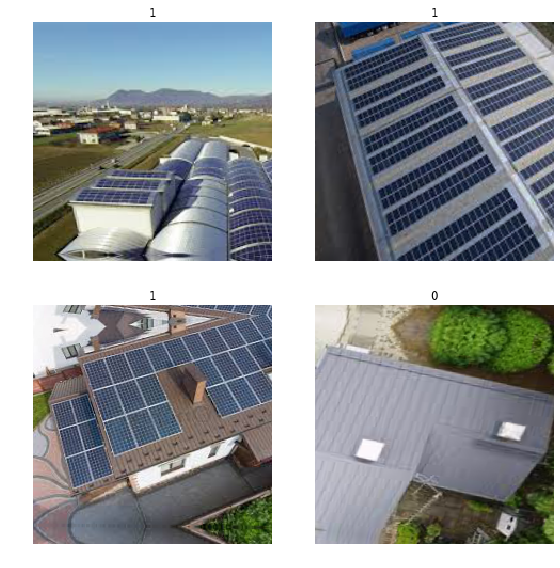

In [15]:
data.show_batch(rows=2)
data.classes

In [16]:
print(data.classes)
len(data.classes),data.c

[0, 1]


(2, 2)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [17]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [18]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [19]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate
1,0.714458,0.485298,0.333333
2,0.588576,0.249422,0.083333
3,0.443860,0.186221,0.083333
4,0.379325,0.172126,0.000000
5,0.337309,0.188936,0.083333


In [ ]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [36]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

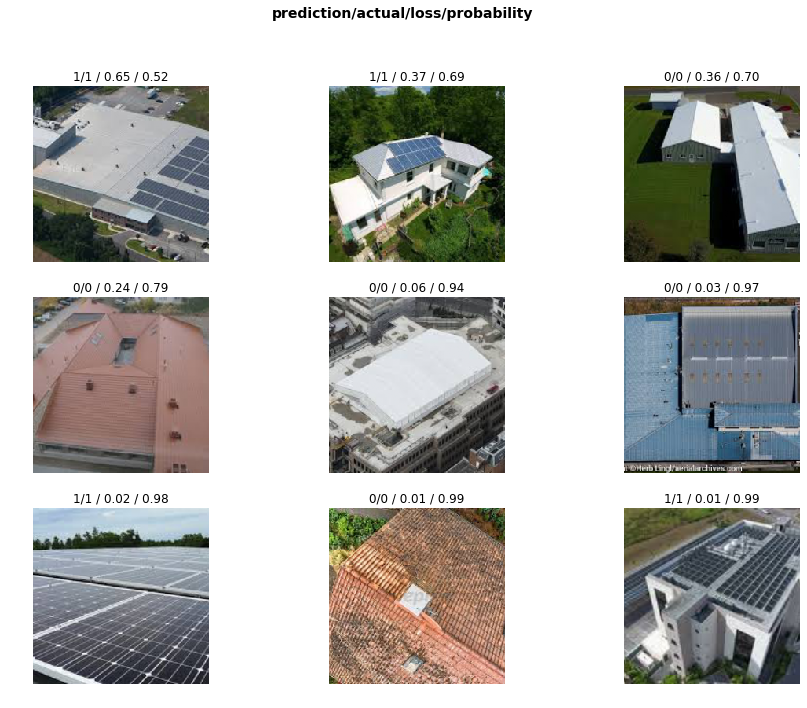

In [37]:
interp.plot_top_losses(9, figsize=(15,11))

In [22]:
doc(interp.plot_top_losses)

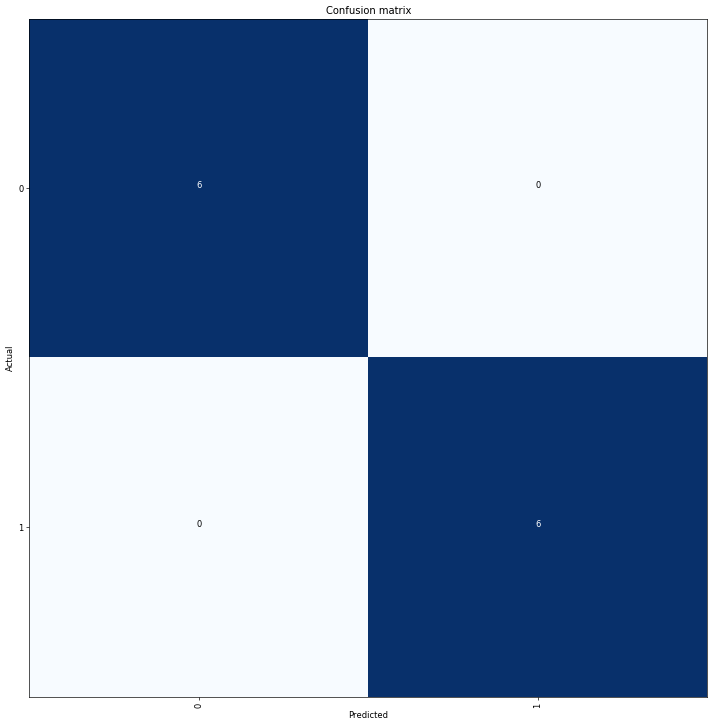

In [38]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [25]:
interp.most_confused(min_val=2)

[]

That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. Details of resnet50 can be found in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [40]:
data = ImageDataBunch.from_csv(path, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [41]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/nbuser/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 80208021.87it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


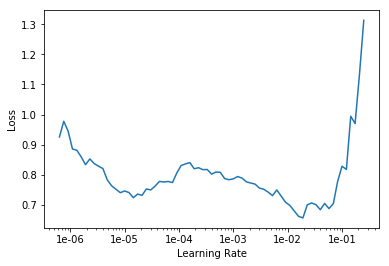

In [42]:
learn.lr_find()
learn.recorder.plot()

In [44]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate
1,0.163094,0.321102,0.250000
2,0.237944,0.344544,0.166667
3,0.251911,0.169342,0.083333
4,0.254990,0.327284,0.166667
5,0.278206,0.379508,0.166667
6,0.248935,0.373013,0.250000
7,0.202801,0.397041,0.250000
8,0.274957,0.316118,0.250000


In [ ]:
learn.save('stage-1-50')

Let's see if full fine-tuning helps:

In [45]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.531207,0.607541,0.250000
2,0.575091,0.647169,0.166667
3,0.461724,0.382128,0.083333


If it doesn't, you can always go back to your previous model.

In [ ]:
learn.load('stage-1-50');

In [46]:
interp = ClassificationInterpretation.from_learner(learn)

In [48]:
interp.most_confused(min_val=2)

[]